In [17]:
# Import calibration functions
# Run this to reimport without having to restart the whole notebook
import radial_velocity_functions
import importlib
importlib.reload(radial_velocity_functions)
from radial_velocity_functions import *

In [2]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt

matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["font.family"] = "serif"
matplotlib.rcParams["font.size"] = 10 
matplotlib.rcParams['figure.dpi'] = 200

#### New functions added to radial_velocity_functions.py

In [88]:
def match_k_features(filenames, correct_for_tellurics=False, log=True, min_feature_count_in_k=50, max_feature_count_in_k=60):
    all_features = [find_features(file, log=False, apply_order_overlap_masking=True, corect_for_tellurics=correct_for_tellurics) for file in filenames]

    # Extract wavelength of all features
    feature_wavelengths = []
    for f in all_features:
        list = [f[i][3] for i in range(len(f))]
        feature_wavelengths.append(list)
    feature_wavelengths = np.concatenate(feature_wavelengths)

    # Do numpy histogram to get count and bin_edges with larger bin size
    xmin, xmax = np.min(feature_wavelengths), np.max(feature_wavelengths)
    Nbins = 100000
    count, bin_edges = np.histogram(feature_wavelengths, bins=Nbins, range=(xmin, xmax))
    bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
    bin_width = (xmax-xmin)/Nbins

    # remove features that are overlaping (if any ..)
    count[np.where(count > max_feature_count_in_k)] = 0

    # remove features that are not present throughout most observations (50+)
    count[np.where(count < min_feature_count_in_k)] = 0

    # Find peaks in histogram
    from findpeaks import findpeaks
    fp = findpeaks(lookahead=1, interpolate=10) # todo: what do these params do? 
    results = fp.fit(count)

    # get df from results
    res_df = results["df"]

    # exclude points that are not peaks (such as valleys)
    res_df = res_df[res_df.peak]

    # get peak index and height
    peak_index = res_df.x 
    peak_height = res_df.y 

    # Remove "peaks" that are below 50 (a lot around zero...)
    peak_index = peak_index[peak_height > 50]
    peak_height = peak_height[peak_height > 50]

    # get wavelength of bin-centers
    peak_wavelength = bin_centers[peak_index]

    # Make dataframe of all features
    df_all_features = []
    days = convert_dates_to_relative_days(get_spectra_dates(filenames))
    for obs, day, i in zip(all_features, days, range(len(all_features))):
        for f in obs:
            fdf = pd.DataFrame({
                "k": np.nan,   # add k, ready to assign 
                "obs": i,
                "day": day,
                "x": [f[0]],
                "y": [f[1]],
                "y_err": [f[2]],
                "x_peak": f[3],
                "x_peak_index": f[4],
                "order": f[5]
            })
            df_all_features.append(fdf)

    df_all_features = pd.concat(df_all_features, ignore_index=True)

    # Loop through all features
    for i in range(len(df_all_features)):
        
        # get feature peak (wavelength)
        feature_peak = df_all_features.iloc[i].x_peak
        
        # loop through all k wavelengths
        for k, λ in enumerate(peak_wavelength):

            # check if feature peak is in the bin of wavelength k, if so asign. 
            if λ > feature_peak - bin_width and λ < feature_peak + bin_width:
                df_all_features.loc[i, "k"] = k
                break

    if log:
        print(f"Categorized {len(df_all_features[df_all_features.k >= 0])} features with k ranging from 0 to {np.nanmax(df_all_features.k)}. {(len(df_all_features[df_all_features.k >= 0])/len(df_all_features) * 100):.3}% of the found features.")

    return df_all_features


def parse_matrix_results_feature(result, coords):
    
    size = np.max(np.max(coords)) + 1
    diff_matrix, diff_matrix_err, diff_matrix_valid = make_nan_matrix(size), make_nan_matrix(size), make_nan_matrix(size)

    for coord, shifts in zip(coords, result):

        # Split 
        rv, err, valid = shifts[0], shifts[1], shifts[2]

        x = coord[0]
        y = coord[1]

        diff_matrix[x, y] = rv
        diff_matrix_err[x, y] = err
        diff_matrix_valid[x, y] = valid
        
    return diff_matrix, diff_matrix_err, diff_matrix_valid


and a better way to handle order overlap is to crop off the wavelengths at the start of each order which also appeared at the end of the previous order. So modifications to find_features()

In [ ]:
def find_features(filename, 
                    plot_orders = None, 
                    plot_features_in_order = None, 
                    log=True, 
                    max_frac_err = 0.1,                 # maximum fractional error in intensity
                    min_order_goodness = 0.7,           # Min fraction of data in an order that should be left after filtering for the order to be included. 
                    # min_peak_dist = 50,               # minimum distance (in pixels) between peaks  
                    min_peak_dist = 5,                  # minimum distance (in pixels) between peaks  
                    min_peak_prominence = 0.25,         # minimum height of peak from base (not zero)
                    is_51_peg = False,                  # 51Peg doesn't have excalibur column so we need different keywords 
                    use_bary_correction = True,         # True if you want to use "wavelength" column filtered by pixel_mask.
                    scale_up_errors = False,            # scale errors by sqrt{3}
                    custom_error_scale = None,          # scale errors by a constant
                    order_padding=0,                    # pad orders with a number of pixels, so we exclude features found at the edges
                    apply_order_overlap_masking=False   # true to crop off the wavelengths at the start of each order which also appeared at the end of the previous order.
    ):
    
    """ Returns list of features x_values (angstrom by default), y_values, y_err_values, x_peak_location, peak_index, order """
    """                          0                               1         2             3                4           5     """

    
    feature_slices = []
    fits_data = load_spectra_fits(filename)
    orders_n = shape(fits_data["spectrum"])[0]

    # 51Peg data files have different column names
    is_51_peg = ("peg" in filename)

    orders = np.arange(0, orders_n)
    end_x = -1
    for index, order in enumerate(orders):
        
        if is_51_peg:
            pixel_mask  = fits_data['PIXEL_MASK'][order]
            y           = fits_data['spectrum'][order][pixel_mask]
            og_y        = y # copy of original y data before filtering
            y_err       = fits_data['uncertainty'][order][pixel_mask]
            continuum   = fits_data['continuum'][order][pixel_mask]
            x           = fits_data['bary_wavelength'][order][pixel_mask]
        elif not use_bary_correction:
            excalibur_mask  = fits_data['EXCALIBUR_MASK'][order]    # filter by EXCALIBUR_MASK
            y           = fits_data['spectrum'][order][excalibur_mask]
            og_y        = y # copy of original y data before filtering
            y_err       = fits_data['uncertainty'][order][excalibur_mask]
            continuum   = fits_data['continuum'][order][excalibur_mask]
            x           = fits_data['excalibur'][order][excalibur_mask]
        else:
            excalibur_mask  = fits_data['EXCALIBUR_MASK'][order]    # filter by EXCALIBUR_MASK
            y           = fits_data['spectrum'][order][excalibur_mask]
            og_y        = y # copy of original y data before filtering
            y_err       = fits_data['uncertainty'][order][excalibur_mask]
            continuum   = fits_data['continuum'][order][excalibur_mask]
            x           = fits_data['BARY_EXCALIBUR'][order][excalibur_mask]

        # skip order if no good data
        if len(x) == 0 or len(y) == 0:
            continue

        if scale_up_errors:
            y_err = y_err * np.sqrt(3)

        if custom_error_scale is not None:
            y_err = y_err * custom_error_scale

        # Normalize intensity by continuum 
        y = y/continuum
        y_err = y_err/continuum

        # filter by fractional error (10% doesn't actually remove anything)
        frac_err = y_err/y
        frac_err_mask = (0 < frac_err) & (frac_err < max_frac_err) # reject if larger than 10% and negative
        y = y[frac_err_mask]
        y_err = y_err[frac_err_mask]
        x = x[frac_err_mask]

        # Skip order if we filtered out more than 1 - min_order_goodness of the data (bad order ... )
        if len(y) / len(og_y) < min_order_goodness:
            # print("Order bad:", len(y), "/", len(og_y), "=", len(y) / len(og_y))
            continue

        # Now invert peaks
        y = 1 - y

        # order padding
        if order_padding > 0:
            x = x[order_padding:-order_padding]
            y = y[order_padding:-order_padding]
            y_err = y_err[order_padding:-order_padding]

        # orders overlap, so we can trim off the wavelengths in the beginning of each order,
        # which appeared at the end of the previous order. 
        if apply_order_overlap_masking:
            if end_x > 0:
                for j, x_val in enumerate(x):
                    if x_val > end_x:
                        x = x[j:]
                        y = y[j:]
                        y_err = y_err[j:]
                        break

            # save last x for next order
            end_x = x[-1]


        peaks = func_find_peaks(y, min_peak_dist, min_peak_prominence)
        peak_locs = peaks[0]
        peak_height = peaks[5] # peak height from y=0 
        
        # Plot
        if plot_orders is not None and (plot_orders == order).any() or plot_orders == -1:
            plt.figure(figsize=(30,3))
            plt.plot(x, y, ".")
            plt.plot(x[peak_locs], peak_height, "o", color="C3", label=f"{order}. order")
            plt.ylabel("1 - Continuum normalized counts")
            plt.xlabel("Wavelength [Å]")
            plt.legend(loc = "upper right")
        
        # If less than 10 peaks skip order
        if len(peak_locs) < 5:
            continue

        peak_index_ranges = get_peak_index_ranges(peak_locs, peak_range_size=30)

        # feature_slices = []
        for index, range in enumerate(peak_index_ranges):
            start, end = range

            if len(x[start:end]) != 0 and len(y[start:end]) != 0: # sometimes these lists come out empty. 
                feature_slices.append([x[start:end], y[start:end], y_err[start:end], x[peak_locs[index]], peak_locs[index], order])

            if plot_features_in_order is not None and (plot_features_in_order == order).any():
                plt.figure(figsize=(10,3))
                plt.plot(x[start:end], y[start:end], ".")
                plt.plot(x[peak_locs[index]], peak_height[index], "o", color="C3", label=f"$k = {index}$")
                plt.legend(loc = "upper right")
        
    if log:
        print(len(feature_slices), "peaks found")

    return np.asarray(feature_slices, dtype=object)

#### Compute individual feature shift

In [95]:
filenames = get_spectra_filenames_without_duplicate_dates(SPECTRA_PATH_34411)
df_all_features = match_k_features(filenames, correct_for_tellurics=True)

[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..
[findpeaks] >Interpolating 1d-vector by factor 10
Categorized 18463 features with k ranging from 0 to 319.0. 43.9% of the found features.


In [96]:
k_list = np.arange(np.max(df_all_features.k))
        
# Define function for each process
def compute(k):

    # get feature
    df_feature_k = df_all_features[df_all_features.k == k]

    # get coords for this feature
    coords_list = compute_coords(len(df_feature_k))
    
    # compute shifts
    feature_result = []
    for coords in coords_list:
        x, y = coords[0], coords[1]
        f1 = df_feature_k.iloc[x]
        f2 = df_feature_k.iloc[y]
        shifts = compute_feature_shift(f1.x, f1.y, f1.y_err, f1.x_peak, f2.x, f2.y, f2.x_peak, plot=False, interp_size = 1000, return_df=False, return_extra=True)
        feature_result.append(shifts)
        
    # reduce matrix
    m, final_shifts, final_shifts_err, _ = matrix_reduce(*parse_matrix_results_feature(feature_result, coords_list), SPECTRA_PATH_34411, plot=False, with_date_duplicates=False, center_around_zero=True)
    
    # get observations days specific to feature k
    feature_k_days = np.asarray(df_feature_k.day)

    return [final_shifts, final_shifts_err, feature_k_days]


if __name__ == '__main__':
    import multiprocess
    pool = multiprocess.Pool(processes = 6)
    
    result = []
    print("Computing shifts for all files combinations...")
    for r in tqdm(pool.imap_unordered(compute, k_list), total=len(k_list)):
    # for r in pool.imap_unordered(compute, k_list):
        result.append(r)
        
    np.save(RV_RESULTS_PATH + "HD34411_k_shifts_tel.npy", result)
    print("Finished!")

result = np.asarray(result)



Computing shifts for all files combinations...


100%|██████████| 319/319 [07:51<00:00,  1.48s/it]

Finished!


In [129]:
res = np.load(RV_RESULTS_PATH + "HD34411_k_shifts.npy", allow_pickle=True)
res_tel = np.load(RV_RESULTS_PATH + "HD34411_k_shifts_tel.npy", allow_pickle=True)

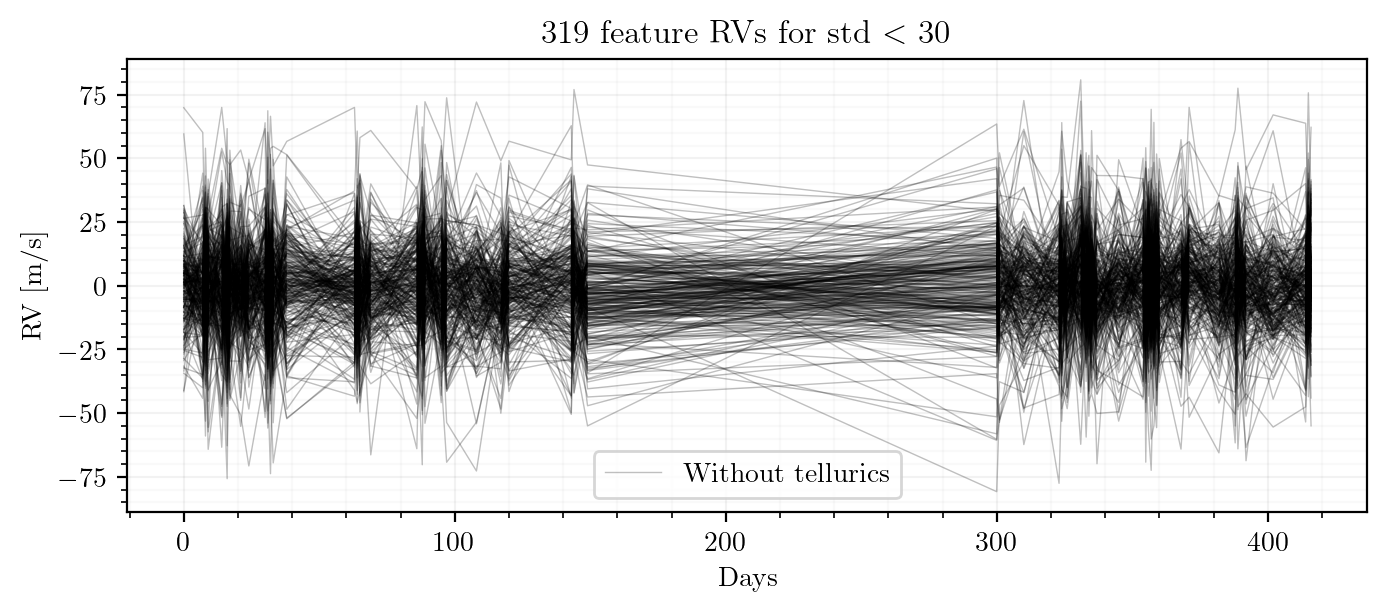

In [112]:
fig, ax = plt.subplots(figsize=(8,3))
legend_set = False
for i in range(len(res)):
    rv, rv_err, days = res[i]
    if np.std(rv) < 30:
        ax.plot(days, rv, lw=0.5, color="k", alpha=0.25, label=("Without tellurics" if not legend_set else "_nolegend_"))
        legend_set = True

# ax.set_title(f"{len(res)} feature RVs without tellurics...")
ax.set_title(f"{len(res)} feature RVs for std $<$ 30")
ax.set_ylabel("RV [m/s]")
ax.set_xlabel("Days")
ax.legend()
ax_add_grid(ax)

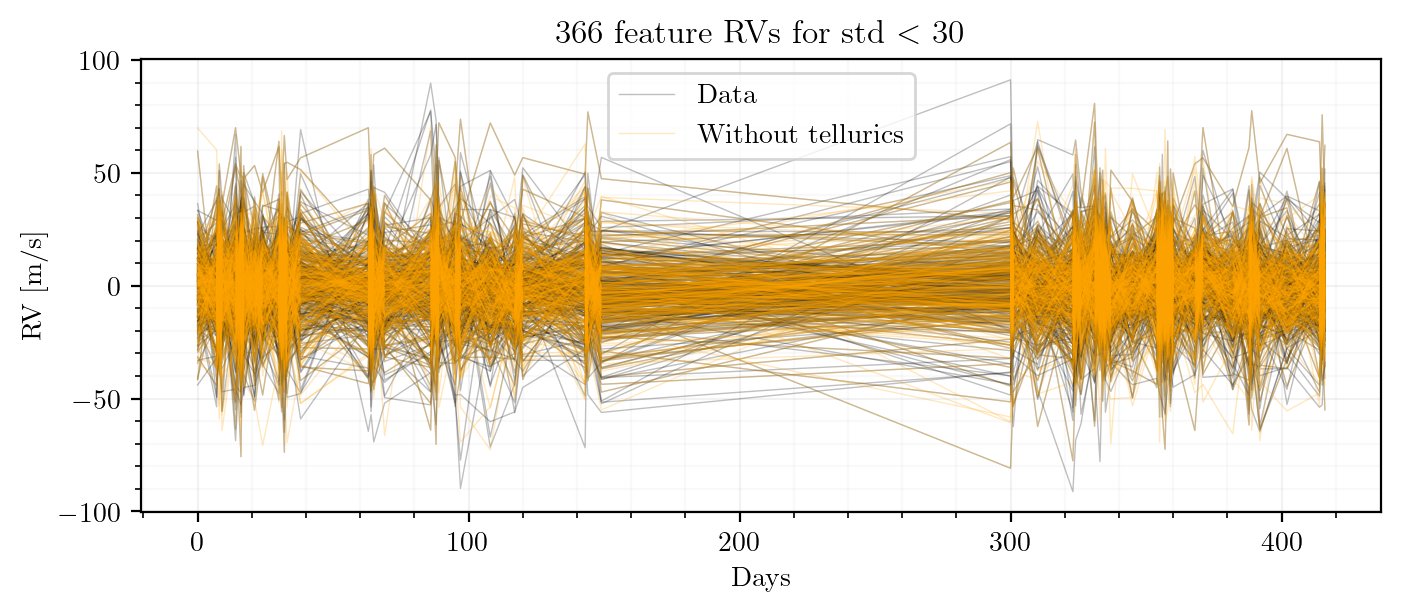

In [130]:
fig, ax = plt.subplots(figsize=(8,3))
legend_set = False
for i in range(len(res)):
    rv, rv_err, days = res[i]
    if np.std(rv) < 30:
        ax.plot(days, rv, lw=0.5, color="k", alpha=0.25, label=("Data" if not legend_set else "_nolegend_"))
        legend_set = True

# ax.set_title(f"{len(res)} feature RVs without tellurics...")
ax.set_title(f"{len(res)} feature RVs for std $<$ 30")
ax.set_ylabel("RV [m/s]")
ax.set_xlabel("Days")
ax.legend()
ax_add_grid(ax)

legend_set = False
for i in range(len(res_tel)):
    rv, rv_err, days = res_tel[i]
    if np.std(rv) < 30:
        ax.plot(days, rv, lw=0.5, color="orange", alpha=0.25, label=("Without tellurics" if not legend_set else "_nolegend_"))
        legend_set = True

ax.legend()

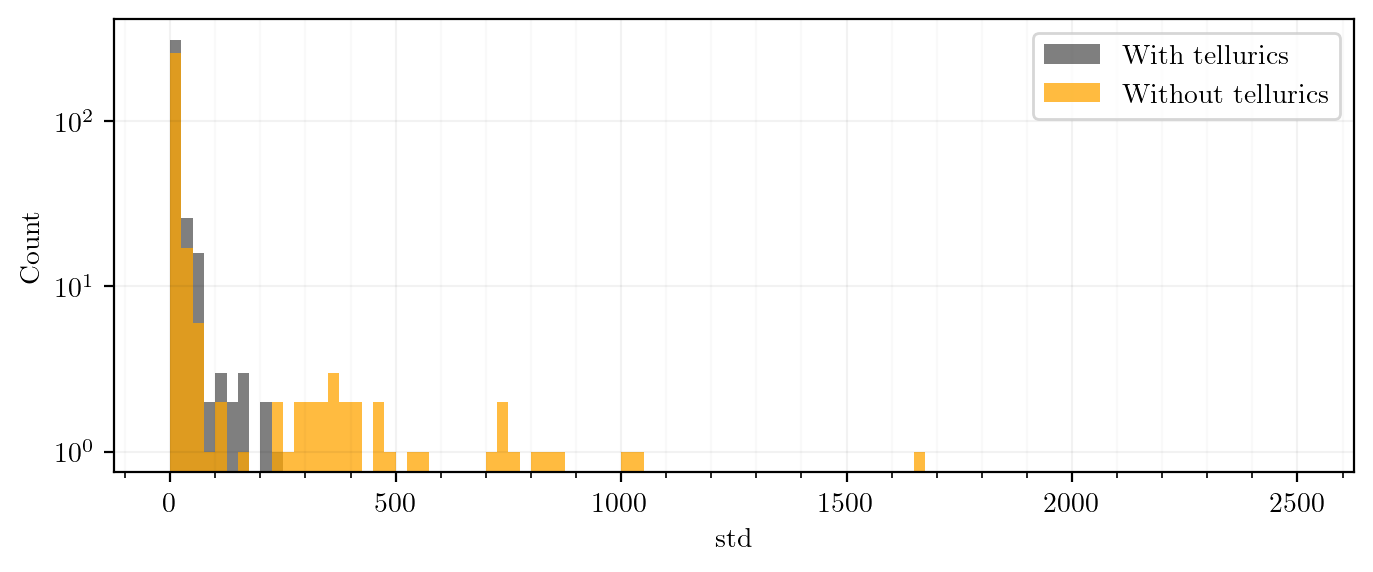

In [137]:
stds = []
stds_tel = []
for i in range(len(res)):
    rv, rv_err, days = res[i]
    stds.append(np.std(rv))

for i in range(len(res_tel)):
    stds_tel.append(np.std(res_tel[i][0]))

fig, ax = plt.subplots(figsize=(8,3))
hist_range = (0, 2500)
ax.hist(stds, bins=100, color='k', alpha=0.5, range=hist_range, label="With tellurics");
ax.hist(stds_tel, bins=100, color='orange', alpha=0.75, range=hist_range, label="Without tellurics");
ax.set_yscale("log")
ax.set_xlabel("std")
ax.set_ylabel("Count")
ax_add_grid(ax)
ax.legend()

Text(0, 0.5, 'Count')

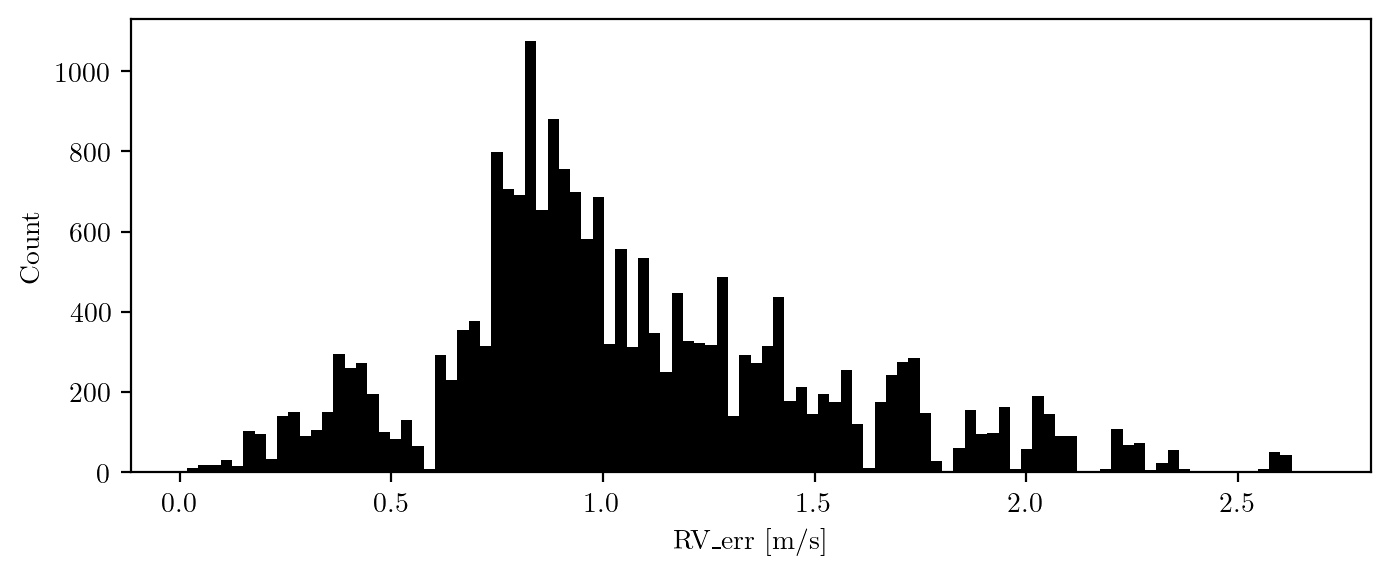

In [85]:
err = []
for i in range(len(res)):
    rv, rv_err, days = res[i]
    err.append(rv_err)
err = np.concatenate(err)
fig, ax = plt.subplots(figsize=(8,3))
ax.hist(err, bins=100, color="k");
ax.set_xlabel("RV_err [m/s]")
ax.set_ylabel("Count")

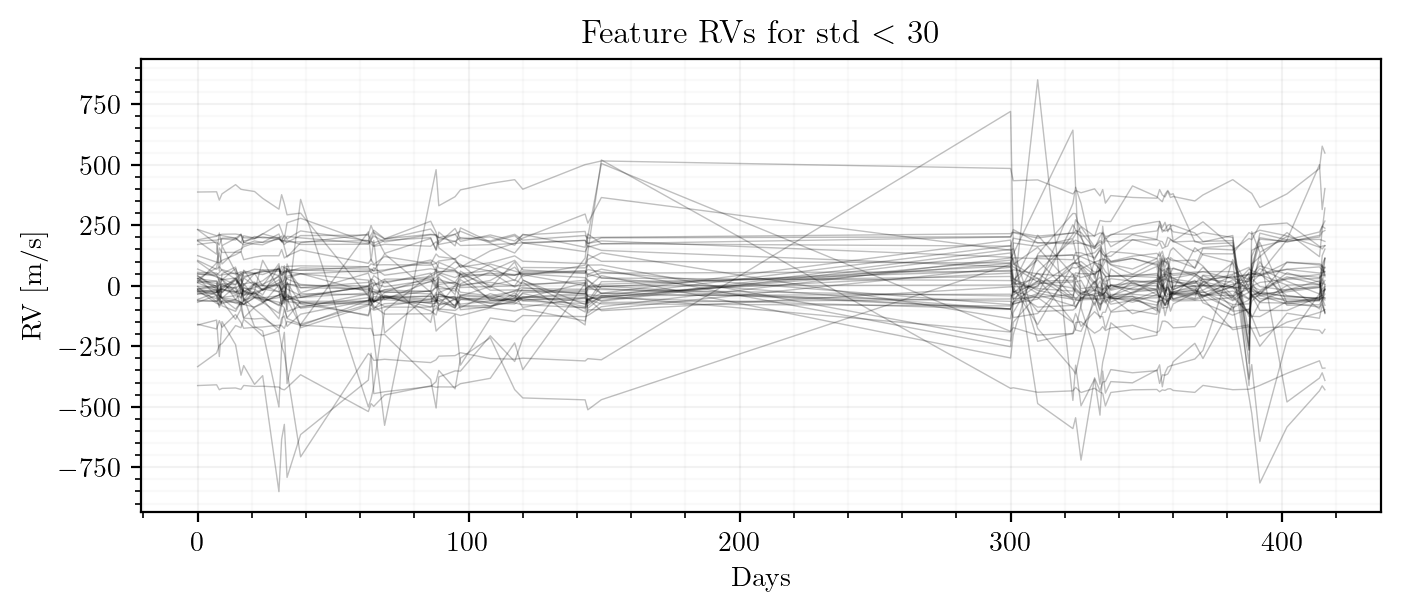

In [89]:
fig, ax = plt.subplots(figsize=(8,3))
for i in range(len(res)):
    rv, rv_err, days = res[i]
    if np.std(rv) > 30:
        ax.plot(days, rv, lw=0.5, color="k", alpha=0.25)

ax.set_title("Feature RVs for std $<$ 30")
ax.set_ylabel("RV [m/s]")
ax.set_xlabel("Days")
ax_add_grid(ax)